In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

In [70]:
filepath = r"C:\Users\user\Projetos\densities4risk\data\processed\database.parquet"
df = pd.read_parquet(filepath)

In [72]:
df.ticker.unique()

array(['AAVE-USD', 'AAVE_USD', 'ADA-USD', 'ADA_USD', 'AGRO3SA', 'ARB-USD',
       'ARB', 'ARB_USD', 'AVAX-USD', 'AVAX_USD', 'BCH-USD', 'BCH',
       'BCH_USD', 'BEEF3SA', 'BNB-USD', 'BNB_USD', 'BOVA11SA', 'BRFS3SA',
       'BTC-USD', 'BTC', 'BTC_USD', 'BVSP', 'CRO-USD', 'CRO_USD',
       'CSNA3SA', 'DAI-USD', 'DAI_USD', 'DOGE-USD', 'DOGE_USD', 'DOT-USD',
       'DOT_USD', 'ES', 'ETH-USD', 'ETH', 'ETH_USD', 'GGBR4SA', 'GSPC',
       'HBAR-USD', 'HBAR_USD', 'IDIVSA', 'IFIXSA', 'JBSS3SA', 'KLBN11SA',
       'LINK-USD', 'LINK', 'LINK_USD', 'LTC-USD', 'LTC', 'LTC_USD',
       'PETR3SA', 'PETR4SA', 'RAIZ4SA', 'SHIB-USD', 'SHIB_USD', 'SMLLSA',
       'SOL-USD', 'SOL', 'SOL_USD', 'SUI', 'SUZB3SA', 'TON-USD',
       'TON_USD', 'TRX-USD', 'TRX', 'TRX_USD', 'USDC-USD', 'USDC_USD',
       'USDT-USD', 'USDT_USD', 'VALE3SA', 'XLM-USD', 'XLM_USD', 'XMR-USD',
       'XMR_USD', 'XRP-USD', 'XRP_USD'], dtype=object)

In [137]:
TICKER = 'BVSP'

In [138]:
df_bvsp = df[df["ticker"]==TICKER].loc[:,["datetime", "open", "high", "low", "close"]].dropna().drop_duplicates()
df_bvsp.set_index("datetime", inplace=True)

In [139]:
df_bvsp.shape

(9782, 4)

In [140]:
df_bvsp.head(10)

,open,high,low,close
datetime,,,,
2025-05-09 10:00:00,136232.234375,136520.687500,136232.234375,136520.687500
2025-05-09 10:05:00,136504.984375,136746.140625,136323.515625,136746.140625
2025-05-09 10:10:00,136767.453125,136889.765625,136687.546875,136771.546875
2025-05-09 10:15:00,136799.515625,136862.937500,136754.781250,136862.937500
2025-05-09 10:20:00,136904.328125,136960.406250,136852.875000,136865.062500
2025-05-09 10:25:00,136841.671875,136917.109375,136743.640625,136743.640625
2025-05-09 10:30:00,136730.796875,136835.718750,136695.531250,136790.937500
2025-05-09 10:35:00,136825.265625,137004.140625,136780.921875,137004.140625
2025-05-09 10:40:00,137012.593750,137136.687500,136911.125000,137136.687500


In [141]:
df_bvsp.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

In [142]:
start_time = '10:00'
end_time = '17:00'
freq = '5T'  # 5 minutes

In [143]:
# Create a complete time index for each day
def complete_day(group):
    day = group.index[0].date()
    full_index = pd.date_range(
        f"{day} {start_time}",
        f"{day} {end_time}",
        freq=freq
    )
    return group.reindex(full_index)

In [144]:
# Apply to each day
df_complete = df_bvsp.groupby(df_bvsp.index.date, group_keys=False).apply(complete_day)

C:\Users\user\AppData\Local\Temp\ipykernel_8952\350790738.py:4: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [145]:
# Reset index and rename column
df_complete = df_complete.reset_index().rename(columns={'index': 'datetime'})

In [146]:
# Added rows
df_complete.shape[0] - df_bvsp.shape[0]

163

In [147]:
df_complete.interpolate(method="linear", inplace=True)

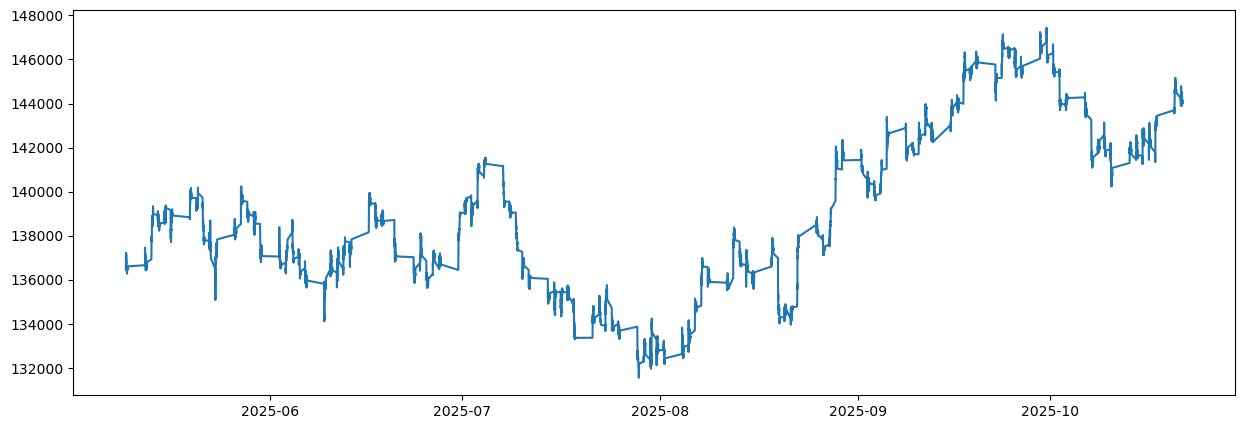

In [148]:
plt.figure(figsize=(15,5))


plt.plot(df_complete.datetime, df_complete.close)

plt.show()

In [149]:
# Retornos
df_complete["R_t"] = df_complete["close"].pct_change()
df_complete["r_t"] = np.log(df_complete["close"]) - np.log(df_complete["close"].shift(1))

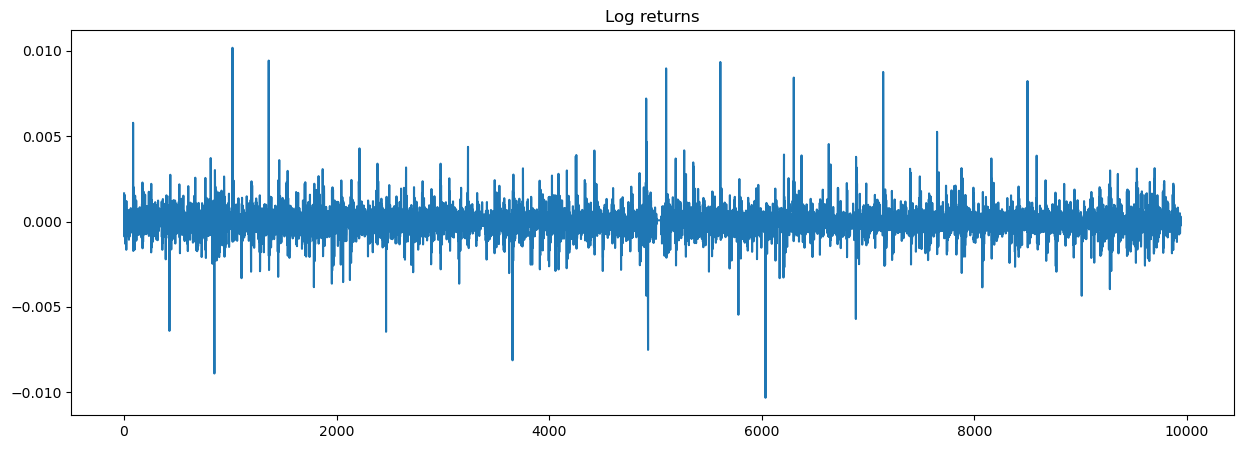

In [150]:
plt.figure(figsize=(15,5))

df_complete.r_t.plot()
plt.title("Log returns")

plt.show()

In [151]:
# Cria Series de retornos
bvsp = pd.Series(df_complete.r_t.values, index=df_complete.datetime)

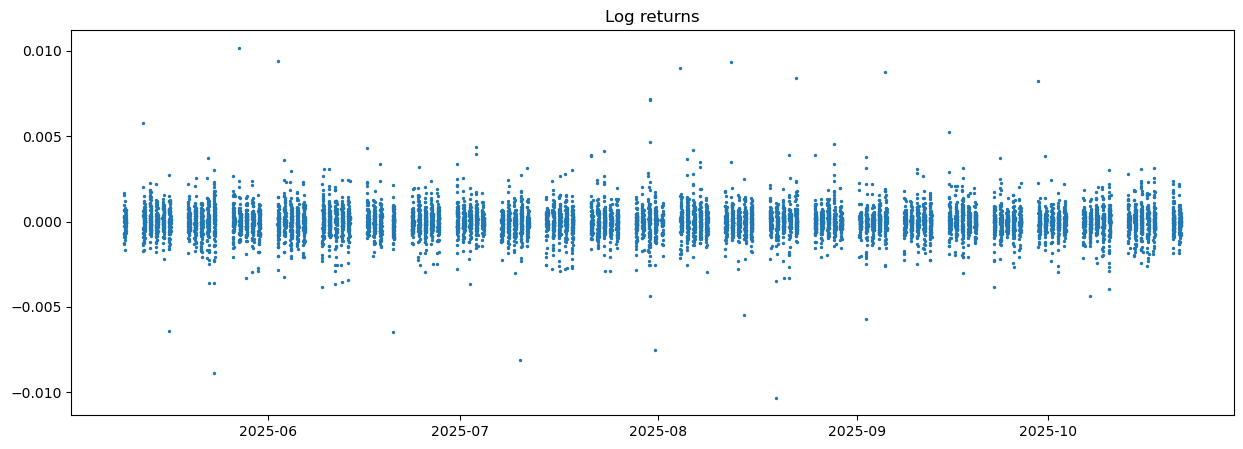

In [152]:
plt.figure(figsize=(15,5))

plt.scatter(bvsp.index, bvsp, s=2)

plt.title("Log returns")

plt.show()

In [153]:
df_complete = df_complete.dropna(subset="r_t")

[]

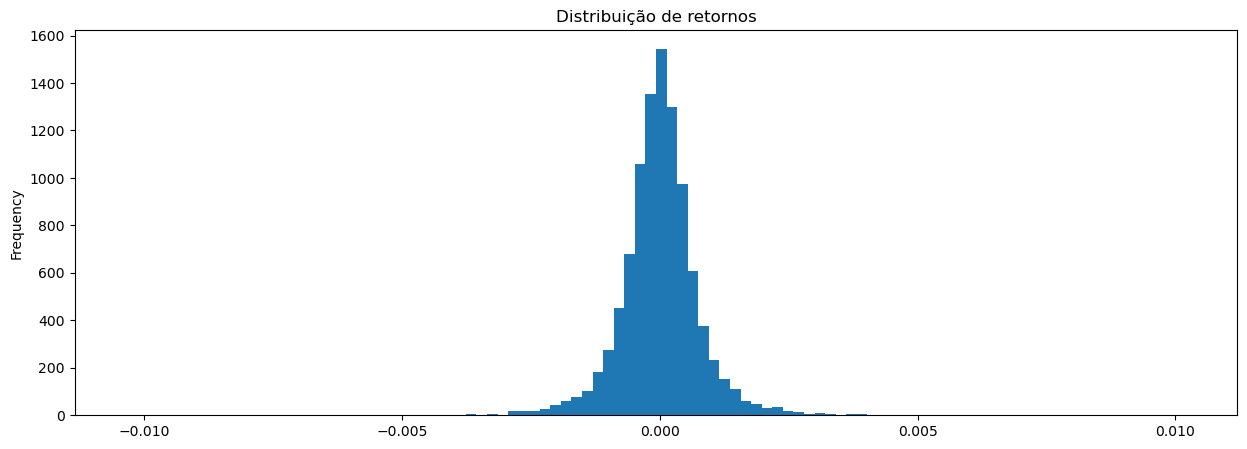

In [154]:
plt.figure(figsize=(15,5))

df_complete.r_t.plot(kind="hist", bins=100)
plt.title("Distribuição de retornos")

plt.plot()

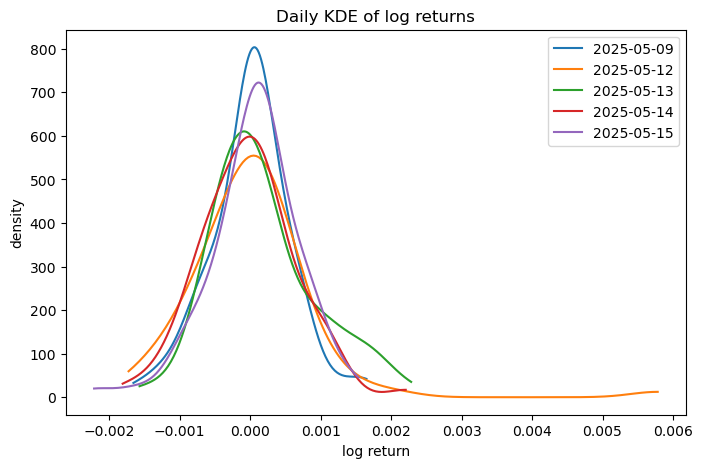

In [155]:
# Group by day
grouped = df_complete.groupby(df_complete['datetime'].dt.date)

# Compute KDE per day and store results
kde_results = {}

for day, group in grouped:
    data = group['r_t'].dropna()
    if len(data) > 1:  # need at least 2 points
        kde = gaussian_kde(data)
        # Evaluate on a grid for visualization
        x_grid = np.linspace(data.min(), data.max(), 200)
        y_kde = kde(x_grid)
        kde_results[day] = (x_grid, y_kde)

# Example: plot a few KDEs
plt.figure(figsize=(8,5))
for i, (day, (x, y)) in enumerate(kde_results.items()):
    if i >= 5:  # plot first 5 days
        break
    plt.plot(x, y, label=str(day))
plt.title('Daily KDE of log returns')
plt.xlabel('log return')
plt.ylabel('density')
plt.legend()
plt.show()

In [156]:
# kde_results = {day: (x_grid, y_kde)} from previous step

# Sort days and build aligned matrices
days_sorted = sorted(kde_results.keys())

# ---- Step 1: build a common X grid (important for smooth 3D surface)
all_x = np.concatenate([kde_results[d][0] for d in days_sorted])
x_common = np.linspace(all_x.min(), all_x.max(), 200)

# ---- Step 2: evaluate each day's KDE on the common grid
Z = []
for d in days_sorted:
    kde = kde_results[d][0]
    density = kde_results[d][1]
    # Interpolate densities to common x grid
    z_interp = np.interp(x_common, kde, density)
    Z.append(z_interp)

Z = np.array(Z)
Y = np.arange(len(days_sorted))  # day index

# ---- Step 3: create 3D surface
fig = go.Figure(data=[go.Surface(
    x=x_common,   # log return values
    y=Y,          # day index
    z=Z,          # densities
    colorscale='Turbo'
)])

# ---- Step 4: layout and labels
fig.update_layout(
    title='Daily Kernel Density Estimates of Log Returns',
    scene=dict(
        xaxis_title='Log return',
        yaxis_title='Day',
        zaxis_title='Density',
        yaxis=dict(
            tickmode='array',
            tickvals=np.linspace(0, len(days_sorted)-1, 10, dtype=int),
            ticktext=[str(days_sorted[i]) for i in np.linspace(0, len(days_sorted)-1, 10, dtype=int)]
        )
    ),
    height=700
)

fig.show()